# Importando wradlib y verificando la versión

In [1]:
import wradlib as wl
import pylab as pl
import numpy as np
print(wl.__version__)

1.9.0


# Ejemplo de la estimación de precipitación basada en un radar o cadena de procesamiento de datos de radar

RAW, los productos de reflectividad sin procesar pueden servir para obtener información visual útil sobre la distribución espacial de campos de lluvia.

Sin embargo, para utilizar las observaciones de radar meteorológico para estudios cuantitativos (por ejemplo, en modelos hidrológicos o para asimilarlos a modelos de predicción meteorológica numérica), los datos deben procesarse cuidadosamente para tener en cuenta las fuentes de errores típicas, como los ecos en el suelo (ecos parásitos), atenuación de la señal de radar, o incertidumbres en la relación Z/R.

Además, podría ser necesario transformar los datos de coordenadas polares a coordenadas cartesianas, o combinar observaciones de diferentes ubicaciones de radar en áreas superpuestas en una coordenada común (composición). Y al final, normalmente sería útil visualizar la distribución espacial de la lluvia en un mapa. Muchos usuarios también necesitan cuantificar el error potencial (incertidumbre) de su estimación de lluvia basada en datos.

Estos son solo algunos de los pasos que pueden ser necesarios para que los datos de radar sean útiles en un entorno de aplicación cuantitativa específico. Todos los pasos juntos se denominan normalmente "cadena de procesamiento de datos de radar". 

<b>ωradlib</b> fue diseñado para ayudarlo a establecer su propia cadena de procesamiento, adaptada a sus requisitos específicos. A continuación, proporcionaremos un esquema de una cadena de procesamiento típica, paso a paso. Es posible que no necesite todos los pasos para su propio flujo de trabajo, o puede que necesite pasos que aún no se incluyen aquí.



## Ejemplo 1: Lectura de datos

Los datos de radar muchas veces se encuentran codificados de formas que wradlib no puede decodificar, por ello es importante considerar que wradlib unicamente adminte un par de formatos, como la implementación ODIM_H5, NetCDF y algunos formatos utilizados por el Servicio Meteorológico Alemán. 
Wradlib promete estar actualizando la base de datos para aumentar los algoritmos de decodificación disponibles.

El tipo de dato básico utilizado en wradlib es una matriz multidimensional, numpy.ndarray. Tal matriz podría, por ejemplo, representan una cuadrícula polar o cartesiana, o una serie de observaciones del pluviómetro. Los métadatos se administran normalmente como diccionarios de python. 



<Figure size 720x576 with 0 Axes>

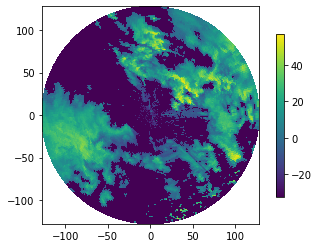

In [2]:
# Lectura de un archivo DX del servicio meteorológico Aleman que contiene un plan position indicator (PPI)
#file = wl.util.get_wradlib_data_file('dx/raa00-dx_10908-0806021655-fbg---bin.gz')
path = "/home/aceron/Documentos/GitHub/Tesis/wradlib-data-master/dx/raa00-dx_10908-0806021655-fbg---bin.gz"
#print(file) 
data, metadata = wl.io.read_dx(path)#file)
#print("data",data)
#print("metadata",metadata)
pl.figure(figsize=(10,8))
ax, pm = wl.vis.plot_ppi(data)
cbar = pl.colorbar(pm, shrink=0.75)

In [3]:
# Tupla de datos (angulo:filas,radio:columnas)
print("{}°, {} bins".format(data.shape[0],data.shape[1]))
# Llaves del metadatos
print(metadata.keys())

360°, 128 bins
dict_keys(['producttype', 'datetime', 'radarid', 'bytes', 'version', 'cluttermap', 'dopplerfilter', 'statfilter', 'elevprofile', 'message', 'elev', 'azim', 'clutter'])


<Figure size 720x576 with 0 Axes>

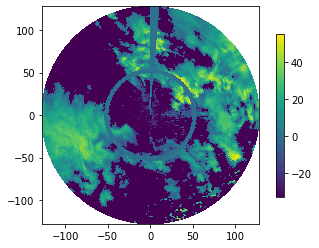

In [4]:
#Dibujando anillos a los datos
data2 = np.copy(data)
for i in range(5):
    data2[i,:] = data2[i,:]*0
    data2[:,50+i] = data2[:,50+i]*0
pl.figure(figsize=(10,8))
ax, pm = wl.vis.plot_ppi(data2)
cbar = pl.colorbar(pm, shrink=0.75)

Se puede acceder a los metadatos usando las llaves. El objeto que contiene a los datos es una malla polar con 360° azimut y 128 contenedores de rango.

## Remoción del desorden

El desorden es un eco no meteorológico. Estos son causados por la interacción del rayo del radar y objetos en la superficie de la tierra (en ejemplo, montañas o edificios altos) o en el aire (en ejemplo, aviones o pajaros). Estos objetos pueden causar altas reflectividades debido a grandes secciones de dispersión. El desorden estático, si no es removido efficientemente por filtros doppler, pueden causar ecos permantes que introducirarn un severo sesgo en aplicaciones.
Por ello, una eficiente identificación y remosición del desornen es indispensable. 
La remosión del desorden se pueden basar en mpasa státicos or en filtros dinámicos. Normalmente, el desorden estático es más notables en mapasa de precipitación acumulada sobre periodos de varias semanas o meses. Es recomendable generar tales mapasa acumulativos para crear mapas de desorden estático que a su vez se pueden utilizar para eliminar el desorden estático de una imagen y llenar los vación resultantes por interpolación.

Text(0.5, 1.0, 'Mapa del desorden')

<Figure size 720x720 with 0 Axes>

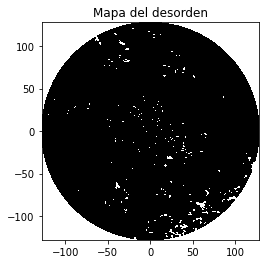

In [5]:
# Utilización de filtro de ecos parásitos Gabella et al., 2002
#https://docs.wradlib.org/en/stable/zreferences.html#gabella2002
desorden = wl.clutter.filter_gabella(data, tr1=12,n_p=6, tr2=1.1)
pl.figure(figsize=(10,10))
ax, pm = wl.vis.plot_ppi(desorden, cmap=pl.cm.gray)
pl.title("Mapa del desorden")

In [6]:
desorden

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

El resultado es un array booleano que indica la posición del desorden. Puede ser utilizado para interpolar los valores de todos esos puntos con los valores que no desordenados, como en la siguiente linea

<Figure size 720x720 with 0 Axes>

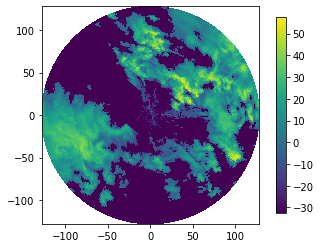

In [7]:
data_ord = wl.ipol.interpolate_polar(data,desorden)
pl.figure(figsize=(10,10))
ax, pm = wl.vis.plot_ppi(data_ord)
cbar = pl.colorbar(pm,shrink=0.9)

## Corrección en la atenuación

La atenuación cauada por lluvias intensas o por el radomo pueden causar subestimaciónes graves de la lluvia para los dispositivos de banda C y banda X. Para tales radares, la situaciones con fuertes lluvias requieren una corrección de los efectos de atenuación. El enfoque general con radares monopolarizados es que utilizan un enfoque recursivo de tipo gate-by-gate, ver más en <a href="https://docs.wradlib.org/en/stable/zreferences.html#kraemer2008">Kraemer et al., 2008</a> para una introducción a ete concepto.
Básicamente, la atenuación específica k de la primera puerta de alcance se calcula mediante la relación k-Z. Con base en k, la reflectividad de la segund puerta de rango se corrige y luego se usa para clacular la atenuación específica para la segunda puerta y así sucesivamente. 
Aunque tiene inconventiens por su suceptibilidad a comportamientos inestables.

Wradlib proporciona diferentes implementaciones que abordan este problema

In [8]:
# Algoritmo de Jacobi y Heistermann
# https://docs.wradlib.org/en/stable/zreferences.html#jacobi2016
pia = wl.atten.correct_attenuation_constrained(data_ord, a_max=1.67e-4, a_min=2.33e-5,
                                                n_a=100, b_max=0.7, b_min=0.65, n_b=6,
                                                gate_length=1., constraints=[wl.atten.constraint_dbz,
                                                                             wl.atten.constraint_pia],
                                                constraint_args=[[59.0],[20.0]])
data_atncor = data_ord + pia

/opt/anaconda3/envs/tesis/lib/python3.9/site-packages/wradlib/trafo.py:262: RuntimeWarning: overflow encountered in power
  return 10.0 ** (x / 10.0)


La primera linea calcula la atenuación inegral (path integrated attenuation, pia) por cada bin del radar. La segunda linea usa el pia para corregir los valores de reflectividad.
En el siguiente ejemplo se vera el efecto de una atenuación correspondiente a un azimuth de 65 grados

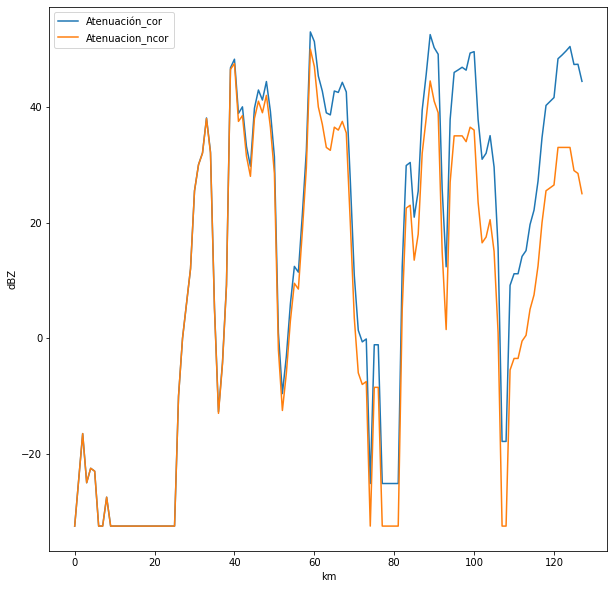

In [9]:
pl.figure(figsize=(10,10))
pl.plot(data_atncor[65], label="Atenuación_cor")
pl.plot(data_ord[65], label="Atenuacion_ncor")
pl.xlabel("km")
pl.ylabel("dBZ")
pl.legend()
#https://docs.wradlib.org/en/stable/atten.html

# Perfil vertical de reflectivilidad

La precipitación es un fenómeno 3 dimensional en el espacio. L distribución vertical de la precipitación (y con esto su reflectivilidad) es típicamente no-uniforme. La anchura de cada paquete de información del radar, incrementa con la distancia del radar a la locación, cada barrido toma muestras de diferentes anchuras. El efecto de los no uniformes PVR y las diferentes anchuras de las muestras deben ser tomadas en cuenta si se está interesado en la precipitación cerca del suelo o en altitudes definidas.

<center><a href="https://docs.wradlib.org/en/stable/vpr.html">link</a></center>


# Conversión de refectivilidad a precipitación

La refectivilidad (Z) y la tasa de precipitación (R) pueden ser relacionados siguiendo la ley de potencias 
$$
R = a Z^b
$$
Los parámetrs $a$ y $b$ dependen del tipo de precipitación en terminos de la distrbución de los tamaños de las gotas y la temperatura del agua. Después de aplicar la relación $Z-R$ se necesita convert de $dBZ$ a $Z$

In [12]:
R = wl.zr.z_to_r(wl.trafo.idecibel(data_atncor))
depths = wl.trafo.r_to_depth(R,300)

Las lineas anteriores usan los parámetros por defecto $a=200, b=1.6$ para la relación $Z-R$. Para calcular la profundidad de la precipitación desde la intensidad de la precipitación, debemos tener específicado un intervalo de integración dado en segundos; en el ejemplo anterior se uso un intervalo de 5 minutos (300 s), correspondiente al intervalo de escaneo

https://docs.wradlib.org/en/stable/notebooks/basics/wradlib_get_rainfall.html
https://docs.wradlib.org/en/stable/zr.html
https://docs.wradlib.org/en/stable/trafo.html

# Acumulación de precipitación

Para muchas aplicaciones, la profundidad del acumulado de la precipitación sobre un intervalo de tiempo específico es requerido, por ejemplo el acumulado diario o de cada hora.
En el siguiente ejemplo, usaremos una serie sintenitca de tiempo para un intervalo de 5 minutos. Si imaginamos que debemos repetir el procedimiento anterior para un día, con barridos de cinco minutos y debemos combinar los arrays de profundidad de lluvia en un array de 3 dimensiónes (tiempo, azimuth, disparos)

In [23]:
intervalos_barrido = wl.util.from_to("2021-01-05 00:00:00", "2021-01-06 00:00:00", 300)
print("Generación de los intervalos de medición")
print(type(intervalos_barrido))
print(intervalos_barrido[-5:])
print(len(intervalos_barrido))
np.random.seed(0)
depths_5min = np.random.uniform(size=(len(intervalos_barrido)-1,360,128))
print("Precipitación cada 5 min")
#print(depths_5min[:-5])
print(depths_5min.shape)
depth_daily = depths_5min.sum(axis=0)
print("Precipitación diaria")
#print(depth_daily)
print(depth_daily.shape)

Generación de los intervalos de medición
<class 'list'>
[datetime.datetime(2021, 1, 5, 23, 40), datetime.datetime(2021, 1, 5, 23, 45), datetime.datetime(2021, 1, 5, 23, 50), datetime.datetime(2021, 1, 5, 23, 55), datetime.datetime(2021, 1, 6, 0, 0)]
289
Precipitación cada 5 min
(288, 360, 128)
Precipitación diaria
(360, 128)


<Figure size 720x576 with 0 Axes>

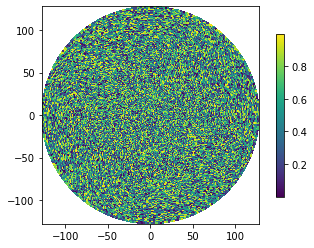

In [28]:
pl.figure(figsize=(10,8))
ax, pm = wl.vis.plot_ppi(depths_5min[1,:,:])
cbar = pl.colorbar(pm, shrink=0.75)

<Figure size 720x576 with 0 Axes>

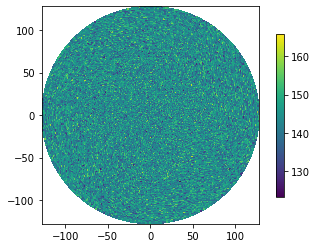

In [29]:
pl.figure(figsize=(10,8))
ax, pm = wl.vis.plot_ppi(depth_daily)
cbar = pl.colorbar(pm, shrink=0.75)

# Georeferencia y proyecciones

Para definir la posición horizontal y verical de los paquetes del radar, necesitamos conocer las coordenadas 3-dimensionales en terminos de longitud, latitud y altitud. La posición espacial de un paquete de radar 3 dimensionadepende de la posición de radar, la elevación en azimuth y el rango del paquete además de algunas supociciones sofre la refraxión de la atmósfera sobre la propagación del paquete. El radar del que se extrajeron los datos se encuentra en Feldber, Alemania con las coordenadas (8.005, 478744,1517)

Usando <i>georef.shperical_to_xyz</i> podemos transformar coorednadas esféricas en cartesianas y la proyección que genera el azimuth

In [33]:
rad_coor = (8.005, 47.8744, 1517) # (lon, lat, alt) en grados y metros
elevacion = 0.5 # en grados
azimuths = np.arange(0,360) # en grados
rangos = np.arange(0, 128000., 1000.) # in metros
polargrid = np.meshgrid(rangos, azimuths) #Dominio

coor, rad = wl.georef.spherical_to_xyz(polargrid[0],polargrid[1],
                                      elevacion, rad_coor)
print(coor)
print(rad)
x = coor[..., 0]
y = coor[..., 1]
print(x,y)

[[[[ 0.00000000e+00  0.00000000e+00  1.51700000e+03]
   [ 6.12190047e-14  9.99782218e+02  1.52578542e+03]
   [ 1.22437882e-13  1.99956235e+03  1.53468862e+03]
   ...
   [ 7.65084782e-12  1.24947827e+05  3.52777099e+03]
   [ 7.71203773e-12  1.25947134e+05  3.55127389e+03]
   [ 7.77322730e-12  1.26946436e+05  3.57489449e+03]]

  [[ 0.00000000e+00  0.00000000e+00  1.51700000e+03]
   [ 1.74486056e+01  9.99629947e+02  1.52578542e+03]
   [ 3.48971749e+01  1.99925781e+03  1.53468862e+03]
   ...
   [ 2.18064026e+03  1.24928797e+05  3.52777099e+03]
   [ 2.19808057e+03  1.25927952e+05  3.55127389e+03]
   [ 2.21552079e+03  1.26927101e+05  3.57489449e+03]]

  [[ 0.00000000e+00  0.00000000e+00  1.51700000e+03]
   [ 3.48918962e+01  9.99173178e+02  1.52578542e+03]
   [ 6.97837198e+01  1.99834427e+03  1.53468862e+03]
   ...
   [ 4.36061627e+03  1.24871712e+05  3.52777099e+03]
   [ 4.39549159e+03  1.25870410e+05  3.55127389e+03]
   [ 4.43036671e+03  1.26869103e+05  3.57489449e+03]]

  ...

  [[-0.00000

Wradlib soporta las proyecciones entre coordenaas geográficas y otros sistemas de referencia. Wradlib usa GDAL/OSR Spatial References Objects como una función parametrada. Basicaménte, se debe crear un objeto OSR usando GDAL o alguna de las funciones de ayuda. 

https://docs.wradlib.org/en/stable/georef.html

In [35]:
# UTM Zone 32, EPSG-Number 32632
utm = wl.georef.epsg_to_osr(32632)
utm_coords = wl.georef.reproject(coor, projection_source=rad,
                                  projection_target=utm)

# Cuadriculando (gridding)

Asumiendo que realizo la transformación de la intensidad de precipitación de los ejemplos anteriores de coordenadas polares a coordenadas cartesinas, o a un conjunto arbritario de puntos en el espacio.
Hemos recuperado las coordenadas cartesianas de los paquetes del radar en el ejemplo de la georeferencia y proyección. Ahora sólo debemos definir la coordinada de referencia y aplicamos la función <i>togrid</i> del modulo librerias wradlib.comp.

En este ejemplo queremos mallar solo un sector del circulo del radar en una malla de 100x100. Para ello debemos definir las coordenadas de la malla referencia,para despues trasnforma los datos polares a una mascara que invalide en la malla algunos puntos del ploteo. Los valores fuera de la malla toman valores NAN

https://docs.wradlib.org/en/stable/generated/wradlib.comp.togrid.html

<ipython-input-37-98a3e9883567>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pm = pl.pcolormesh(xgrid, ygrid, gridded)


(-126946.43557281807, 0.0)

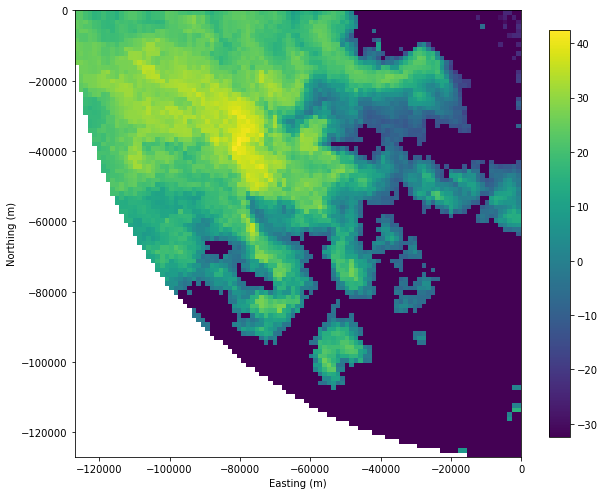

In [37]:
#Crea listas en función de los valores de las coordenadas
xgrid = np.linspace(x.min(), x.mean(), 100)
ygrid = np.linspace(y.min(), y.mean(), 100)
#Crea una malla convinando las listas
grid_xy = np.meshgrid(xgrid, ygrid)
grid_xy = np.vstack((grid_xy[0].ravel(), grid_xy[1].ravel())).transpose()

#Plot
xy=np.concatenate([x.ravel()[:,None],y.ravel()[:,None]], axis=1)

#Transformacion
gridded = wl.comp.togrid(xy, grid_xy, 128000., np.array([x.mean(), y.mean()]), data.ravel(), wl.ipol.Nearest)
gridded = np.ma.masked_invalid(gridded).reshape((len(xgrid), len(ygrid)))

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(111, aspect="equal")
pm = pl.pcolormesh(xgrid, ygrid, gridded)
pl.colorbar(pm, shrink=0.75)
pl.xlabel("Easting (m)")
pl.ylabel("Northing (m)")
pl.xlim(min(xgrid), max(xgrid))
pl.ylim(min(ygrid), max(ygrid))



# Ajuste por las observaciones en la medición de lluvia

El ajuste normalmente se refiere a usar observaciones sobre la cantidad de lluvia que cae en la superficie para corregir errores en la estimación de la precipitación hecha por el radar. <a href="https://docs.wradlib.org/en/stable/zreferences.html#goudenhoofdt2009">Goudenhoofdt et al., 2009</a> provee un excelente procedimiento para realizar un ajuste. 
Una aproximación típica es cuantificar el error del error obtenido por las mediciones del radar en las zonas donde hay pluviómetros, asumiendo que la medición del pluviómetro es precisa. También, se puede suponer que el error es aditivo, multiplicativo o una mezcla de ambos. La mayoría de los enfoques asumen que el herror es heterogéneo en el espacio, por lo tanto, el error en las posicione del puviómetro se interpolará en las ubicaciones de la malla del radar y luego se utilizará para ajustar las estimaciones de lluvia del radar sin procesar.

En el siguiente ejemplo, usaremos un ejemplo unidimensional ilustrativo con datos sintéticos (solo imagine estimaciones de lluvia de radar y observaciones de pluviómetro a lo largo de un rayo de radar).

Primero, creamos la lluvia "verdadera" sintética (verdad):

In [40]:
#Creación de un radar y sus datos
radar_pos = np.arange(0,101)
np.random.seed(0)
Train = np.abs(1.5+np.sin(0.075*radar_pos)) + np.random.uniform(-0.1,0.1,len(radar_pos))
error = 0.75 + 0.015*rad_pos
radar = error * Train + np.random.uniform(-0.1,0.1,len(radar_pos))

#Creación de puvliometros y sus datos
obs_pos = np.array([5,10,15,20,30,45,65,70,77,90])
obs = Train[obs_pos]

Ahora ajustmos la estimación hecha por el radar usando las mediciones de los pluviómetros. Para ello debemos crear un objeto de ajuste creado con los datos que quieras usar para ajustar. Después de ello, se puede llamar al objeto usando los datos que serán ajustados. 

https://docs.wradlib.org/en/stable/adjust.html

/opt/anaconda3/envs/tesis/lib/python3.9/site-packages/wradlib/ipol.py:340: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  self.dists, self.ix = self.tree.query(trg, k=self.nnearest, n_jobs=-1)
/opt/anaconda3/envs/tesis/lib/python3.9/site-packages/wradlib/ipol.py:374: RuntimeWarning: divide by zero encountered in true_divide
  weights = 1.0 / self.dists ** self.p


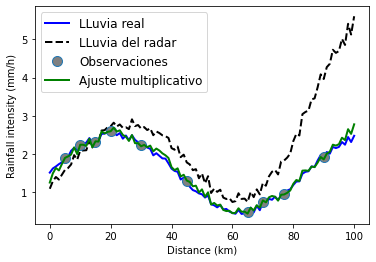

In [42]:
ajuste = wl.adjust.AdjustMultiply(obs_pos,radar_pos,nnear_raws=3)
ajustar = ajuste(obs,radar)

#Comparando la información obtenida
pl.plot(radar_pos, Train, 'k-', label="LLuvia real", linewidth=2, color='blue')
pl.xlabel("Distance (km)")
pl.ylabel("Rainfall intensity (mm/h)")
pl.plot(radar_pos, radar, 'k-', label="LLuvia del radar", linewidth=2., linestyle="dashed")
pl.plot(obs_pos, obs, 'o', label="Observaciones", markersize=10.0, markerfacecolor="grey")
pl.plot(radar_pos, ajustar, '-', color="green", label="Ajuste multiplicativo", linewidth=2., )
pl.legend(prop={'size':12})



# Verificación y control de calidad

Además del ajuste, típicamente se estima un error de precipitación comparando los resultados obteneidos por las mediciones del radar (ya ajustado) y las observaciones hechas en los pluviometros. El modulo wradlib.verify presenta diferentes métodos para hacer comparaciones en las diferentes poisiciones de las observaciones y otras erramientas que permiten calcular erores por medición.

En el siguiente ejemplo se hará uso del la medición del error comparando los datos de precipitación <i>real</i>

https://docs.wradlib.org/en/stable/verify.html

In [44]:
rad_error = wl.verify.ErrorMetrics(Train,radar)
adj_error = wl.verify.ErrorMetrics(Train,ajustar)

print("Errores de medición de los datos no ajustados")
rad_error.pprint()
print("Errores de medición de los datos ajustados")
adj_error.pprint()

Errores de mediciń de los datos no ajustados
{'corr': 0.7,
 'mas': 0.76,
 'meanerr': 0.69,
 'mse': 1.16,
 'nash': -1.38,
 'pbias': 43.5,
 'r2': 0.49,
 'ratio': 1.5,
 'rmse': 1.08,
 'spearman': 0.79,
 'sse': 117.17}
Errores de mediciń de los datos ajustados
{'corr': 0.99,
 'mas': 0.06,
 'meanerr': 0.03,
 'mse': 0.01,
 'nash': 0.98,
 'pbias': 1.9,
 'r2': 0.99,
 'ratio': 1.02,
 'rmse': 0.1,
 'spearman': 0.99,
 'sse': 0.7}


# Exportando datos

Una vez que hayas creado un conjunto de datos bajo tus necesidades, querrás exportarlo a otra aplicación o archivo. Wradlib no hace eso, sin embargo puede usar usted paquetes de python para realizar tales transformaciones

In [46]:
#Usando nunpy
np.savetxt("mydata.txt", data)
#Usando NetCDF
import netCDF4
rootgrp = netCDF4.Dataset('test.nc', 'w', format='NETCDF4')
sweep_xy = rootgrp.createGroup('sweep_xy')
dim_azimuth = sweep_xy.createDimension('azimuth', None)
dim_range = sweep_xy.createDimension('range', None)
azimuths_var = sweep_xy.createVariable('azimuths','i4',('azimuth',))
ranges_var = sweep_xy.createVariable('ranges','f4',('range',))
dBZ_var = sweep_xy.createVariable('dBZ','f4',('azimuth','range',))
azimuths_var[:] = np.arange(0,360)
ranges_var[:] = np.arange(0, 128000., 1000.)
dBZ_var[:] = data

rootgrp.bandwith = "C-Band"
sweep_xy.datetime = "2012-11-02 10:15:00"
rootgrp.close()



PermissionError: [Errno 13] Permission denied: b'test.nc'